## Implementing easy21

In [2]:
import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm import tqdm

%matplotlib inline

In [3]:
class Card(object):
    
    def __init__(self, color=None):
        import random
        self.number = random.randint(1, 10)
        if color is None:
            self.color = 'r' if random.randint(1,3) == 1 else 'b'
        else:
            self.color = color
            
    def __str__(self):
        return 'Card {} color {}'.format(self.number, self.color)
    
    def __repr__(self):
        return '{}{}'.format(self.number, self.color)

In [4]:
print (Card())

Card 6 color b


In [5]:
Card(color='r')

6r

In [6]:
class Easy21(object):
    
    def __init__(self, debug=False):
        import copy
        
        self.debug = debug
        
        self.player = []
        self.dealer = []
    
    def reset(self):
        import copy
        
        self.player = []
        self.dealer = []
        self.player.append(self._draw_card(color='b'))
        self.dealer.append(self._draw_card(color='b'))
        
        return self.player, copy.deepcopy(self.dealer)
    
    def step(self, action):
        if action not in ['stick', 'hit']:
            print ('invalid action, action can only be \'stick\', \'hit\'')
        if action == 'stick':
            player_score = self._cal_score(self.player)
            self._dealer_move()
            dealer_score = self._cal_score(self.dealer)
            
            if self.debug:
                print ('player_score is {}'.format(player_score))
                print ('dealer_score is {}'.format(dealer_score))
            
            if player_score > dealer_score:
                return 1.
            elif player_score < dealer_score:
                return -1.
            elif player_score == dealer_score:
                return 0.
        if action == 'hit':
            self.player.append(self._draw_card())
            if self._cal_score(self.player) == -100:
                return -1.
            else:
                return self.player
            
        
    def _draw_card(self, color=None):
        return Card(color)
        
    def _cal_score(self, cards):
        score = 0
        for card in cards:
            if card.color == 'b':
                score += card.number
            elif card.color == 'r':
                score -= card.number
        if score > 21 or score < 1:
            score = -100
        return score
            
    def _dealer_move(self):
        while self._cal_score(self.dealer) < 17:
            self.dealer.append(self._draw_card())
            if self._cal_score(self.dealer) == -100:
                # dealer burst
                return

## Implementing Monte-Carlo Control

In [7]:
def cal_score(cards):
    score = 0
    for card in cards:
        if card.color == 'b':
            score += card.number
        elif card.color == 'r':
            score -= card.number
    return score

In [8]:
def build_state(player, dealer):
    player_score = cal_score(player)
    dealer_score = cal_score(dealer)
    return (player_score, dealer_score)

In [40]:
def choose_action(state, epsilon=None, test=False, func_appro=False,
                 code_scheme=None):
    if func_appro:
        q_0 = cal_q(encode_sa(state, 0, code_scheme))
        q_1 = cal_q(encode_sa(state, 1, code_scheme))
        action = 0 if q_0 > q_1 else 1
        if q_0 == q_1:
            action = random.choice([0, 1])
    else:
        action = q_table[state].argmax()
        # if tie, choose a random action
        if q_table[state][0] == q_table[state][1]:
            action = random.choice([0, 1])
    
    # roll a dice
    dice = random.random()
    
    if epsilon == None:
        epsilon = n_0 / (n_0 + num_s[state])
    if dice < epsilon and ~test:
        action = random.choice(['stick', 'hit'])
        if action == 'stick':
            action = 0
        elif action == 'hit':
            action = 1
        # increment num_sa, num_s
        num_sa[state+(action,)] += 1
        num_s[state] += 1
        return 'stick' if action == 0 else 'hit'
    else:
        # increment num_sa, num_s
        num_sa[state+(action,)] += 1
        num_s[state] += 1
        return 'stick' if action == 0 else 'hit'

In [11]:
def learn(states, actions, reward):
    for i in range(len(actions)):
        if actions[i] == 'stick':
            actions[i] = 0
        elif actions[i] == 'hit':
            actions[i] = 1
    for state, action in zip(states, actions):
        q_table[state+(action,)] += (reward - q_table[state+(action,)]) / num_sa[state+(action,)]

In [12]:
def plot_q(q_table):    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(8,8),
                                                 nrows=2, ncols=2)
    f_stick = ax1.imshow(q_table[:,:,0], cmap=cm.coolwarm, 
                        interpolation='none')
    fig.colorbar(f_stick, ax=ax1)
    ax1.set_title('stick')

    f_hit = ax2.imshow(q_table[:,:,1], cmap=cm.coolwarm,
                      interpolation='none')
    fig.colorbar(f_hit, ax=ax2)
    ax2.set_title('hit')

    f_value = ax3.imshow(q_table.max(axis=2), cmap=cm.coolwarm,
                        interpolation='none')
    fig.colorbar(f_value, ax=ax3)
    ax3.set_title('value')

    f_strategy = ax4.imshow(q_table[:,:,0] > q_table[:,:,1], 
                           cmap = cm.binary, interpolation='none')
    fig.colorbar(f_strategy, ax=ax4)
    ax4.set_title('strategy: black-stick, white-hit')
    
    plt.show()
    
    return fig

In [13]:
q_table = np.zeros((22,11,2)) #0 stick, 1 hit
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))

# random initialization
# q_table = np.random.randn(22,11,2) * 0.1 #0 stick, 1 hit

n_0 = 100

 12%|█▏        | 49175/400000 [00:06<00:41, 8448.82it/s]

average rewards is -0.46784


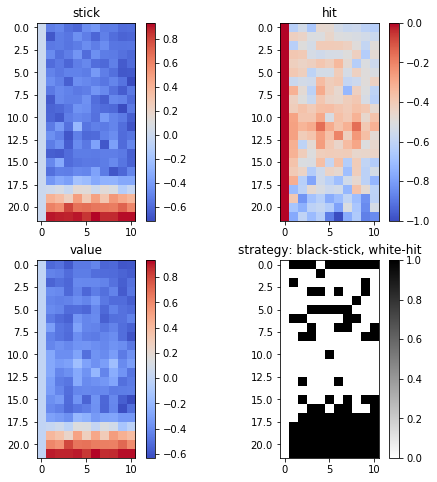

 25%|██▍       | 99629/400000 [00:13<00:42, 7088.70it/s]

average rewards is -0.38816


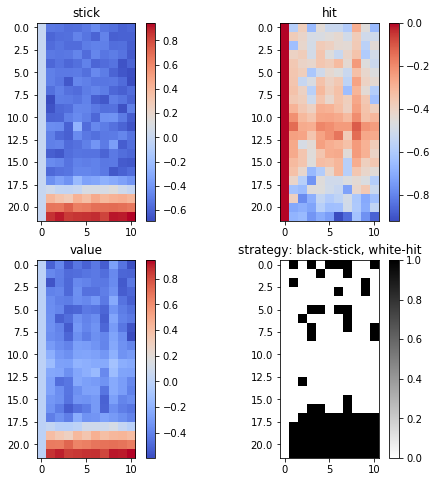

 37%|███▋      | 149422/400000 [00:21<00:37, 6757.12it/s]

average rewards is -0.29916


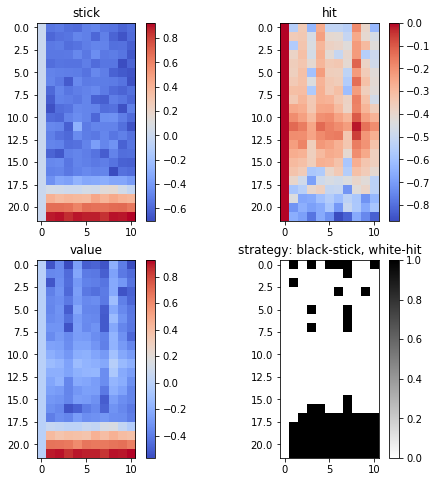

 50%|████▉     | 199893/400000 [00:30<00:31, 6303.72it/s]

average rewards is -0.24132


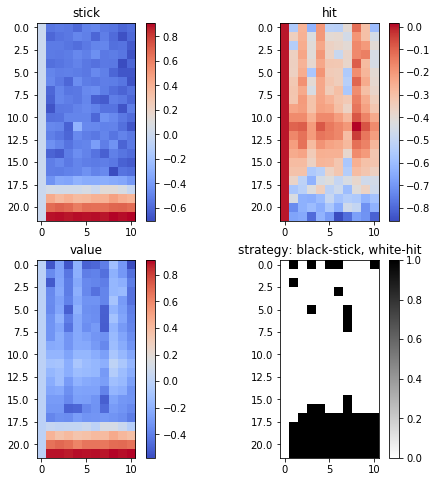

 62%|██████▏   | 249779/400000 [00:38<00:24, 6225.35it/s]

average rewards is -0.22068


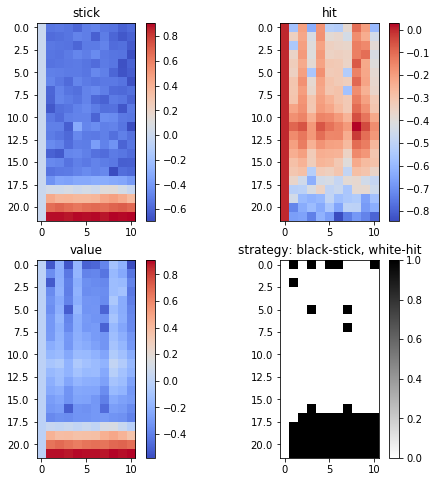

 75%|███████▍  | 299596/400000 [00:47<00:16, 6036.73it/s]

average rewards is -0.2044


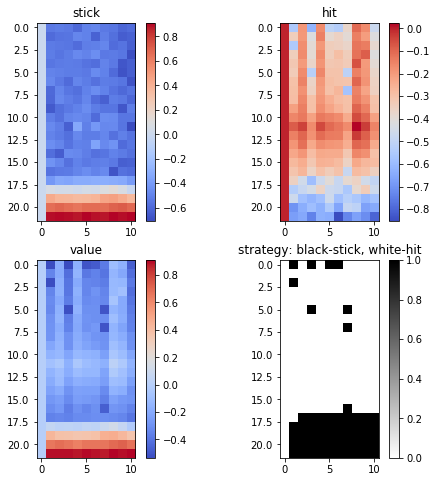

 87%|████████▋ | 349971/400000 [00:57<00:08, 5948.39it/s]

average rewards is -0.1828


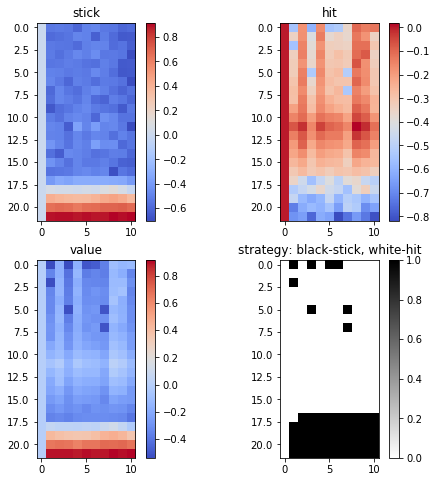

100%|█████████▉| 399532/400000 [01:06<00:00, 6185.79it/s]

average rewards is -0.17026


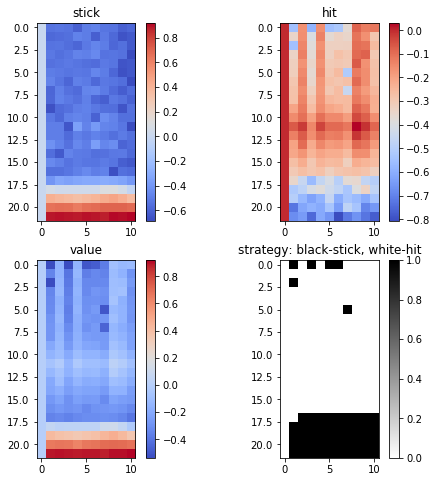

100%|██████████| 400000/400000 [01:06<00:00, 5981.04it/s]


In [155]:
debug = False

episode = 400000

show_every = 50000

rewards = np.zeros(show_every)

game = Easy21(debug=debug)
for e in tqdm(range(episode)):
    player, dealer = game.reset()
    actions = []
    states = []
    while True:
        state = build_state(player, dealer)
        action = choose_action(state)
        actions.append(action)
        states.append(state)
        reward = game.step(action)
        if reward in [-1., 1., 0.,]:
            if debug:
                print ('states')
                print (states)
                print ('actions')
                print (actions)
            learn(states, actions, reward)
            break
        else:
            player = reward

    rewards[e%show_every] = reward
    if e%show_every == show_every - 1:
        print ('average rewards is {}'.format(np.mean(rewards)))
        rewards = np.zeros(show_every)
        
    if e%show_every == show_every - 1:
        fig = plot_q(q_table)

In [146]:
fig.savefig('n_0-100-e-120w-action-stuck')

## Stop on converge

In [127]:
q_table = np.zeros((22,11,2), dtype=np.float32) #0 stick, 1 hit
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))

# random initialization
# q_table = np.random.randn(22,11,2) * 0.1 #0 stick, 1 hit

n_0 = 100

e = 0

In [129]:
debug = False

show_every = 100000
check_every = 10000

rewards = np.zeros(show_every)

game = Easy21(debug=debug)

q_cache = np.ones_like(q_table)

thresh = 0.01

while True:
    
    player, dealer = game.reset()
    actions = []
    states = []
    while True:
        state = build_state(player, dealer)
        action = choose_action(state)
        actions.append(action)
        states.append(state)
        reward = game.step(action)
        if reward in [-1., 1., 0.,]:
            if debug:
                print ('states')
                print (states)
                print ('actions')
                print (actions)
            learn(states, actions, reward)
            break
        else:
            player = reward

    rewards[e%show_every] = reward
    
    if e%show_every == show_every - 1:
        print ('episode {}'.format(e))
    
    if e%show_every == show_every - 1:
        print ('average rewards is {}'.format(np.mean(rewards)))
        rewards = np.zeros(show_every)
        
    if e%show_every == show_every - 1:
        fig = plot_q(q_table)
        
    if e%check_every == check_every - 1:
        if np.all(np.absolute(q_cache - q_table) < thresh):
            # converge
            break
        else:
            q_cache = np.copy(q_table)
        
    e += 1

In [130]:
fig.savefig('n_0-100-thresh-1e-2')

In [131]:
np.save('q_table', q_table)
np.save('gt_value', q_table.max(axis=2))

## Test

In [132]:
episode = 50000

show_every = 50000

rewards = np.zeros(show_every)

game = Easy21(debug=debug)
for e in tqdm(range(episode)):
    player, dealer = game.reset()
    actions = []
    states = []
    while True:
        state = build_state(player, dealer)
        action = choose_action(state, test=True)
        actions.append(action)
        states.append(state)
        reward = game.step(action)
        if reward in [-1., 1., 0.,]:
            # learn(states, actions, reward)
            break
        else:
            player = reward

    rewards[e%show_every] = reward
    if e%show_every == show_every - 1:
        print ('average rewards is {}'.format(np.mean(rewards)))
        rewards = np.zeros(show_every)


100%|██████████| 50000/50000 [00:02<00:00, 17948.35it/s]

average rewards is 0.05218


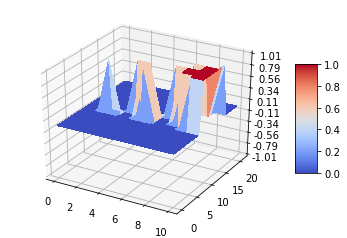

In [133]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data
x_ticks = np.arange(0, 11, 1)
y_ticks = np.arange(0, 22, 1)
x_ticks, y_ticks = np.meshgrid(x_ticks, y_ticks)

z = q_table.argmax(axis=2)

# Plot the surface.
surf = ax.plot_surface(x_ticks, y_ticks, z, 
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Sarsa($\lambda$) - a TD method

## Sarsa($\lambda$) Algorithm for On-policy Control

In [14]:
# load ground truth value, calculated use Mente-Colro above
gt_q_table = np.load('q_table.npy')
gt_value = np.load('gt_value.npy')

In [15]:
def learn_sarsa(state_old, action, state_new, reward, lambda_=None, 
                func_appro=False, code_scheme=None):
    # turn the action into number
    if action == 'stick':
        action = 0
    elif action == 'hit':
        action = 1
        
    # check if use lambda
    if lambda_ is None:
        # not use lambda, update q_table directly
        if state_new is not None:
            # game is not terminated
            q_table[state_old][action] += (reward + q_table[state_new].max() - \
                                          q_table[state_old][action]) /\
                                      num_sa[state_old+(action,)]
        elif state_new is None:
            # game end
            q_table[state_old][action] += (reward - q_table[state_old][action]) /\
                                      num_sa[state_old+(action,)]
    else:
        global e_table
        if not func_appro:
            # use lambda, first increment E(S,A)
            e_table[state_old][action] += 1
            # calculate delta
            if state_new is not None:
                # game is not ended
                delta = (reward + q_table[state_new].max() - q_table[state_old][action]) /\
                        num_sa[state_old][action]
            if state_new is None:
                # game ends
                delta = (reward - q_table[state_old][action]) / num_sa[state_old][action]

            # update q_table, decrease E(S,A), here use a fast version
            e_state_action = experienced_state(e_table)
            for esa in e_state_action:
                q_table[esa] += e_table[esa] * delta / num_sa[esa]
                e_table[esa] *= lambda_
        # use function approximation
        elif func_appro:
            old_code = encode_sa(state_old, action, code_scheme)
            old_sa_q = cal_q(old_code)
            if state_new is not None:
                future_value = eval_value(state_new, code_scheme)
                delta = (reward + future_value - old_sa_q) * learning_rate
            if state_new is None:
                delta = (reward - old_sa_q) * learning_rate
            # update w, e_table
            e_table = e_table * lambda_ + old_code
            update_w(delta * e_table)

In [16]:
def experienced_state(e_table):
    # find the state-action pair that is visited in the episode
    i_positions = np.nonzero(e_table)
    i_row = i_positions[0]
    i_col = i_positions[1]
    i_action = i_positions[2]
    e_state_action = []
    for x,y,z in zip(i_row.tolist(), i_col.tolist(), i_action.tolist()):
        e_state_action.append((x,y,z))
    return e_state_action

In [45]:
def play_and_learn(game, algorithm, params=None, func_appro=False, 
                  code_scheme=None):
    debug = False
    # choose algorithm
    if algorithm =='sarsa':
        # if use lambda
        if params is not None:
            lambda_ = params['lambda']
            use_lambda = True
        else:
            lambda_ = None
            
        # reset the e_table
        global e_table
        if not func_appro:
            e_table = np.zeros((22,11,2))
        elif func_appro:
            p_scheme = code_scheme['player']
            p_code_l = p_scheme['length']
            d_scheme = code_scheme['dealer']
            d_code_l = d_scheme['length']
            e_table = np.zeros(p_code_l * d_code_l * 2)
        
        # draw cards
        player, dealer = game.reset()
        actions = []
        states = []
        # keep play until end
        while True:
            state = build_state(player, dealer)
            action = choose_action(state, func_appro=func_appro,
                                   code_scheme=code_scheme)
            actions.append(action)
            states.append(state)
            # take an action and get reward
            reward = game.step(action)
            
            # check if game ends
            if reward in [-1., 1., 0.,]:
                # end
                if debug:
                    print ('states')
                    print (states)
                    print ('actions')
                    print (actions)
                learn_sarsa(state, action, None, reward, lambda_, func_appro=func_appro, 
                           code_scheme=code_scheme)
                break
            else:
                # not end, retrieve new state
                player = reward
                state_next = build_state(player, dealer)
                reward = 0
                learn_sarsa(state, action, state_next, reward, lambda_, func_appro=func_appro, 
                           code_scheme=code_scheme)
        return reward

In [19]:
# mean_square_error
def mean_square_error():
    return np.mean((q_table - gt_q_table) ** 2)

In [17]:
q_table = np.zeros((22,11,2)) #0 stick, 1 hit
e_table = np.zeros((22,11,2))
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))

# random initialization
# q_table = np.random.randn(22,11,2) * 0.1 #0 stick, 1 hit

n_0 = 100

## Stop on warning debug

In [18]:
debug = False

episode = 10

show_every = 200

rewards = np.zeros(show_every)

params = {'lambda': 0.9}

game = Easy21(debug=debug)

import warnings

# stop on warning
with warnings.catch_warnings():
    warnings.simplefilter('error')
    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

        if e%show_every == show_every - 1:
            fig = plot_q(q_table)

100%|██████████| 10/10 [00:00<00:00, 5528.28it/s]


## Train Sarsa($\lambda$)

In [19]:
q_table = np.zeros((22,11,2)) #0 stick, 1 hit
e_table = np.zeros((22,11,2))
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))

# random initialization
# q_table = np.random.randn(22,11,2) * 0.1 #0 stick, 1 hit

n_0 = 100

 20%|█▉        | 199078/1000000 [00:21<01:28, 9097.68it/s]

average rewards is -0.146055


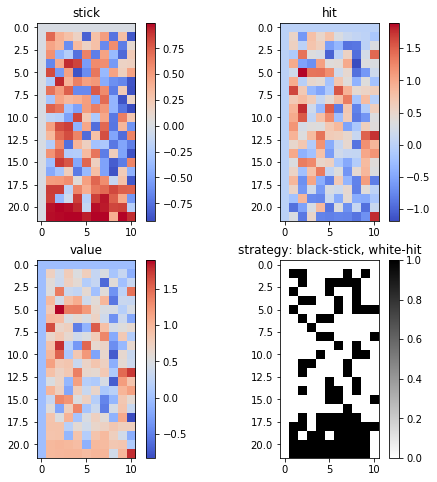

 40%|███▉      | 399440/1000000 [00:44<01:12, 8337.78it/s]

average rewards is -0.145785


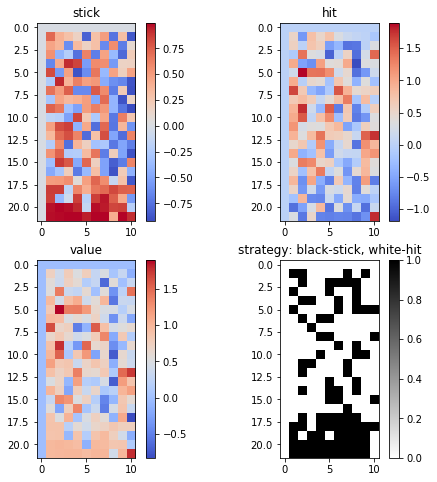

 60%|█████▉    | 599734/1000000 [01:07<00:43, 9256.26it/s]

average rewards is -0.145875


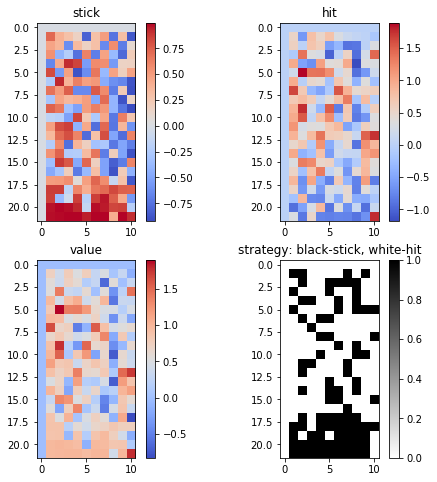

 80%|███████▉  | 799211/1000000 [01:30<00:21, 9457.06it/s]

average rewards is -0.147995


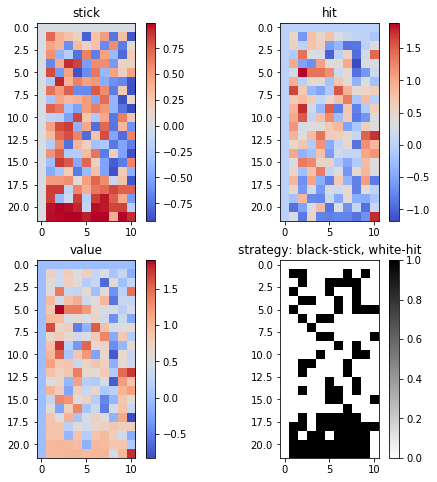

100%|█████████▉| 999607/1000000 [01:52<00:00, 7583.39it/s]

average rewards is -0.144755


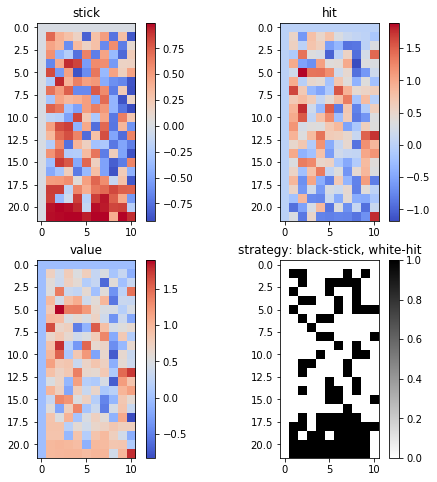

100%|██████████| 1000000/1000000 [01:53<00:00, 8802.94it/s]


In [26]:
debug = False

episode = 100000

show_every = 20000
cal_every = 1000
mse = []

rewards = np.zeros(show_every)

params = {'lambda': 1.}

game = Easy21(debug=debug)

for e in tqdm(range(episode)):
    reward = play_and_learn(game, 'sarsa', params)
    rewards[e%show_every] = reward
    if e%show_every == show_every - 1:
        print ('average rewards is {}'.format(np.mean(rewards)))
        rewards = np.zeros(show_every)

    if e%show_every == show_every - 1:
        fig = plot_q(q_table)
        
    if e%cal_every == cal_every - 1:
        mse.append(mean_square_error())

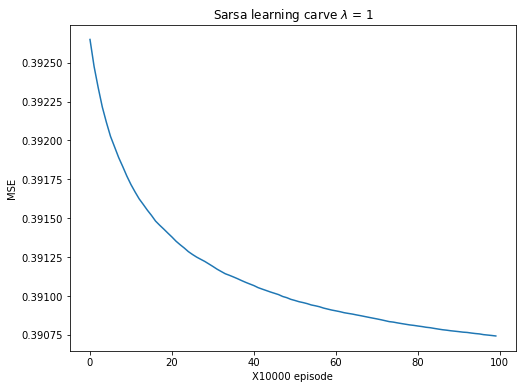

In [28]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(len(mse)), mse)
plt.xlabel('X1000 episode')
plt.ylabel('MSE')
plt.title('Sarsa learning carve $\lambda$ = 1')
plt.show()

In [168]:
fig.savefig('sarsa-lambda-1')

## Sarsa with different $\lambda$

  0%|          | 258/100000 [00:00<00:53, 1869.51it/s]

evaluate lambda 0.0


 19%|█▉        | 19385/100000 [00:02<00:09, 8481.42it/s]

average rewards is -0.0801


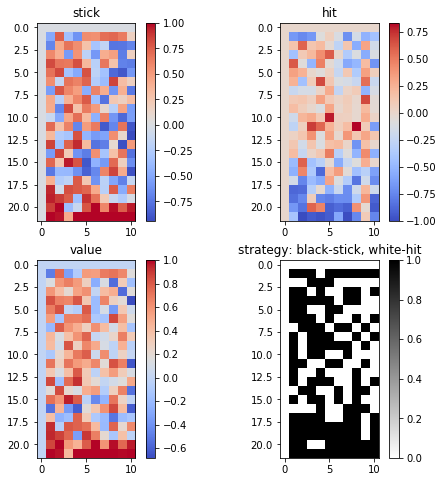

 39%|███▉      | 39108/100000 [00:04<00:05, 10948.38it/s]

average rewards is -0.05475


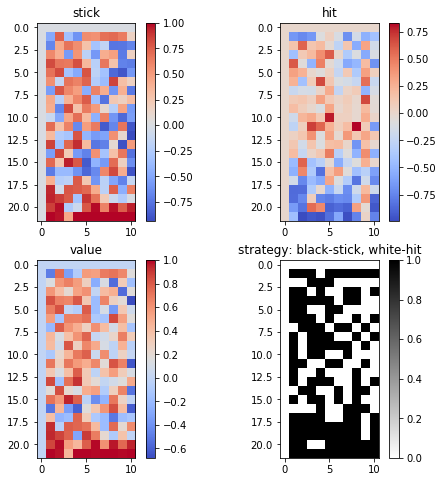

 59%|█████▉    | 59124/100000 [00:07<00:03, 10408.50it/s]

average rewards is -0.04625


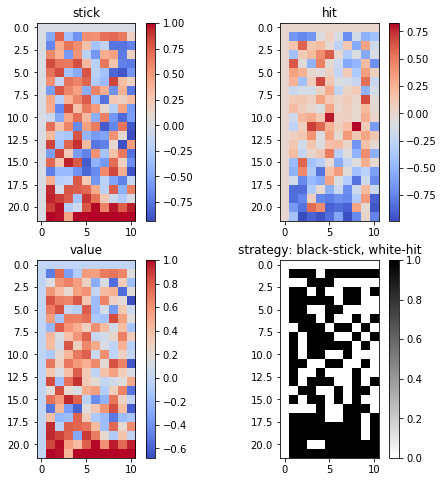

 79%|███████▉  | 79399/100000 [00:10<00:01, 10685.03it/s]

average rewards is -0.0462


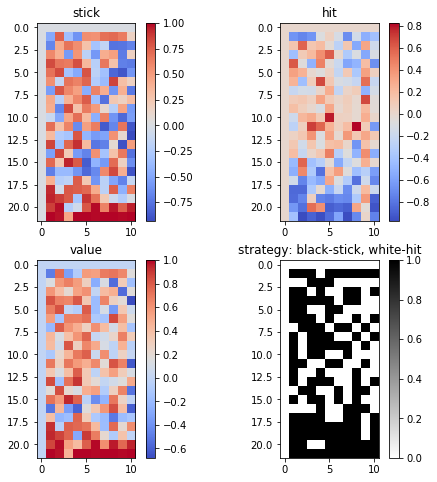

100%|█████████▉| 99508/100000 [00:12<00:00, 9587.50it/s] 

average rewards is -0.04185


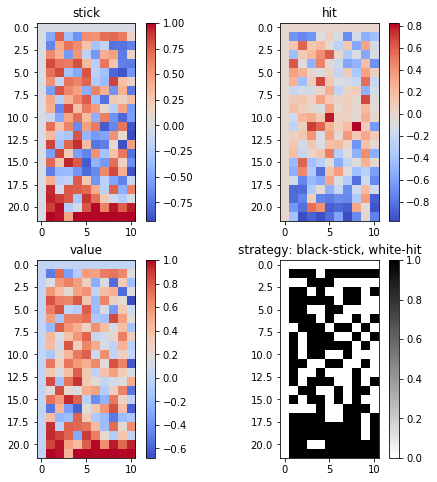

  1%|          | 917/100000 [00:00<00:10, 9166.21it/s]

evaluate lambda 0.1


 19%|█▉        | 19191/100000 [00:02<00:09, 8637.42it/s]

average rewards is -0.09165


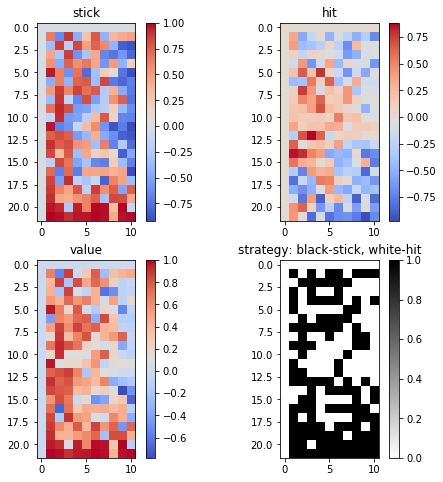

 40%|███▉      | 39654/100000 [00:04<00:06, 9698.12it/s]

average rewards is -0.075


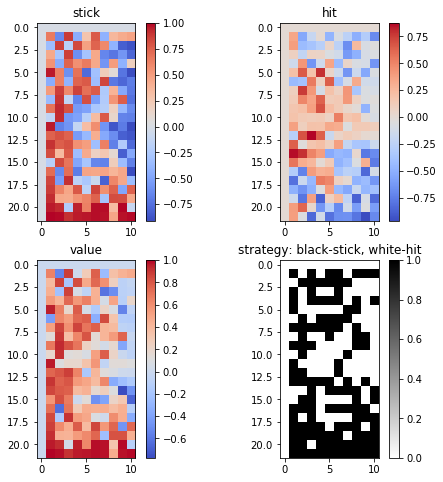

 59%|█████▉    | 59370/100000 [00:07<00:03, 10658.99it/s]

average rewards is -0.06825


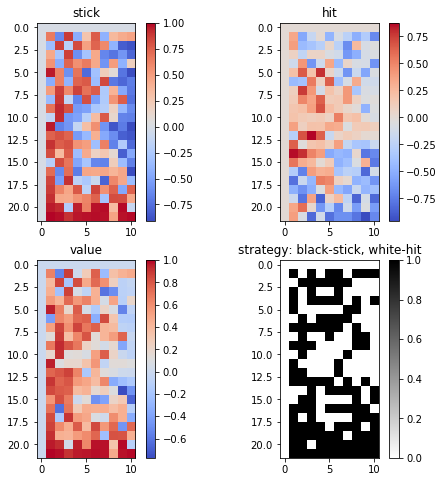

 80%|███████▉  | 79555/100000 [00:10<00:02, 9860.68it/s] 

average rewards is -0.0651


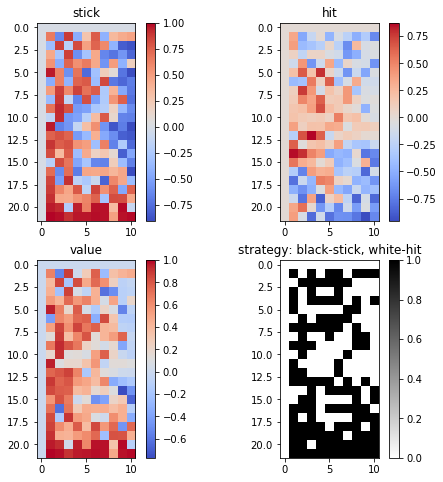

100%|█████████▉| 99783/100000 [00:13<00:00, 10525.89it/s]

average rewards is -0.0544


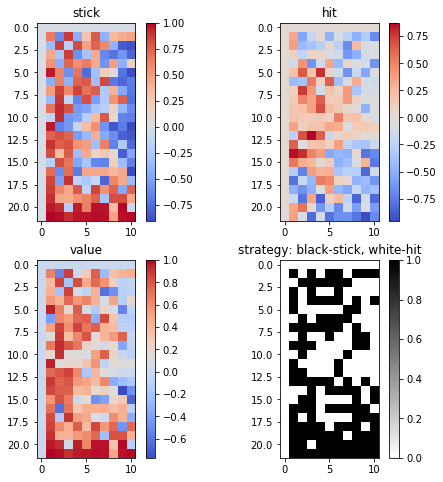

  1%|          | 1012/100000 [00:00<00:09, 10102.93it/s]

evaluate lambda 0.2


 19%|█▉        | 19186/100000 [00:01<00:07, 10180.30it/s]

average rewards is -0.1062


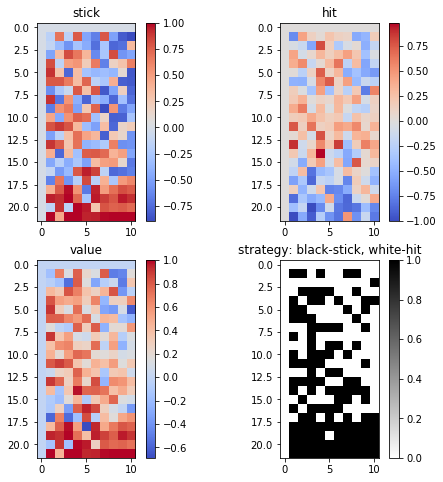

 40%|███▉      | 39748/100000 [00:04<00:06, 9264.95it/s] 

average rewards is -0.1056


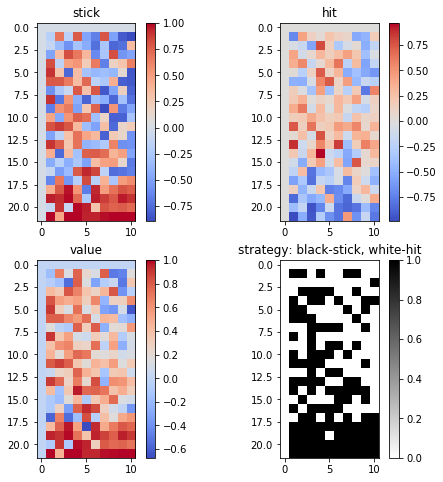

 59%|█████▉    | 58977/100000 [00:07<00:03, 10470.16it/s]

average rewards is -0.0958


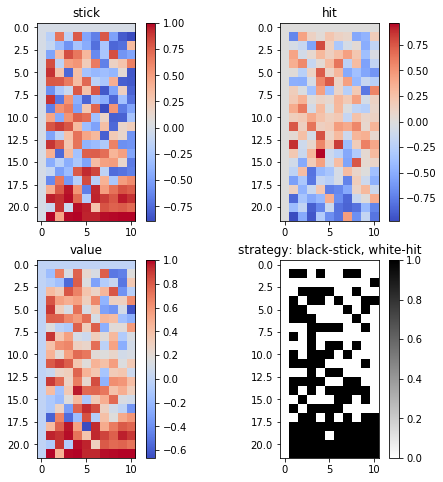

 79%|███████▉  | 79437/100000 [00:10<00:02, 10198.24it/s]

average rewards is -0.09175


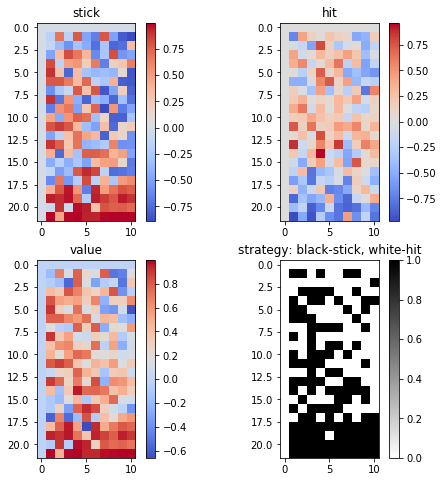

 99%|█████████▉| 99021/100000 [00:13<00:00, 10022.41it/s]

average rewards is -0.08885


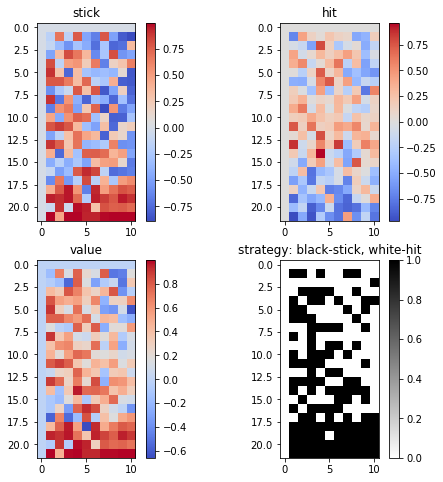

  1%|          | 1029/100000 [00:00<00:09, 10286.36it/s]

evaluate lambda 0.30000000000000004


 20%|█▉        | 19503/100000 [00:01<00:07, 10346.82it/s]

average rewards is -0.08255


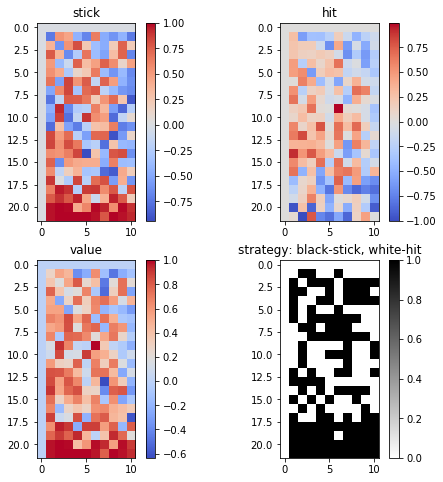

 39%|███▉      | 39200/100000 [00:04<00:06, 9734.66it/s] 

average rewards is -0.06965


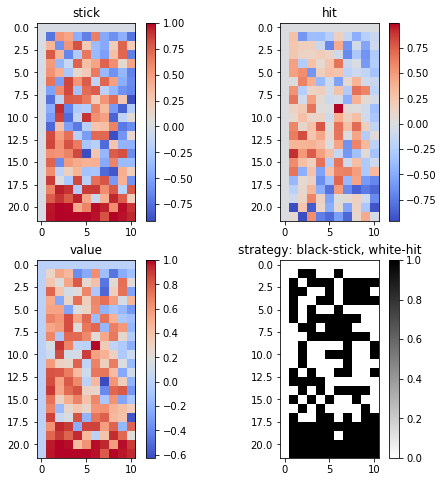

 60%|█████▉    | 59676/100000 [00:07<00:03, 10538.05it/s]

average rewards is -0.0616


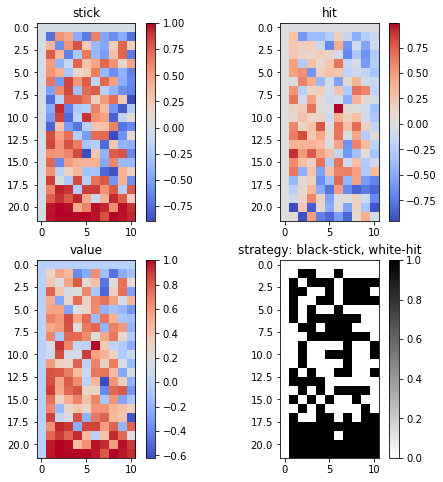

 80%|███████▉  | 79931/100000 [00:10<00:01, 10318.08it/s]

average rewards is -0.04495


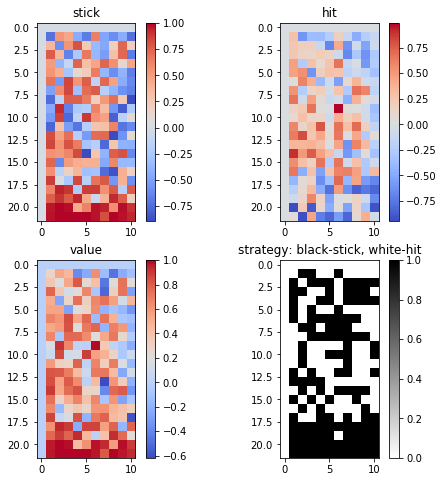

100%|█████████▉| 99658/100000 [00:12<00:00, 10716.48it/s]

average rewards is -0.06515


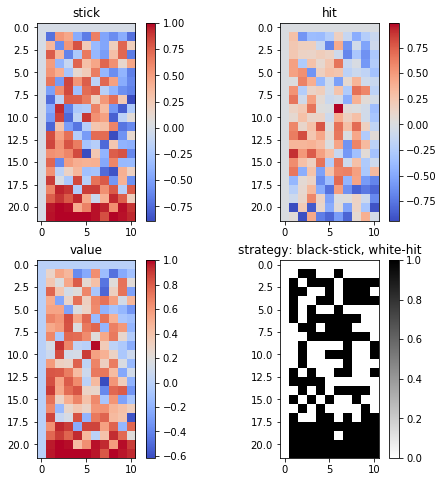

  1%|          | 904/100000 [00:00<00:10, 9037.66it/s]

evaluate lambda 0.4


 19%|█▉        | 19419/100000 [00:01<00:07, 10991.64it/s]

average rewards is -0.09445


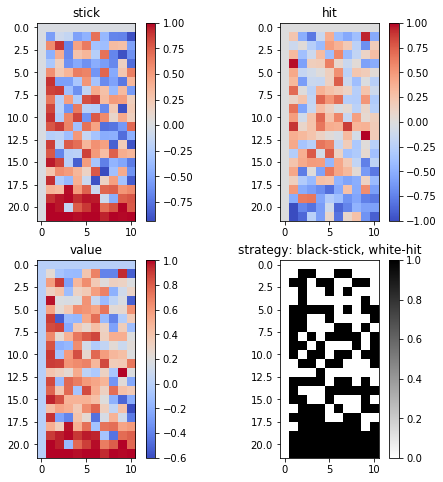

 39%|███▉      | 39454/100000 [00:04<00:05, 10787.87it/s]

average rewards is -0.0879


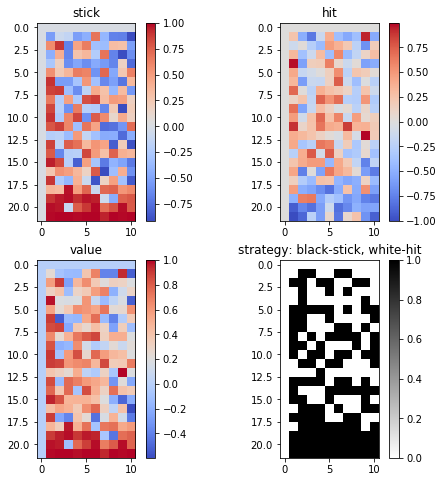

 60%|█████▉    | 59539/100000 [00:07<00:03, 11250.97it/s]

average rewards is -0.0822


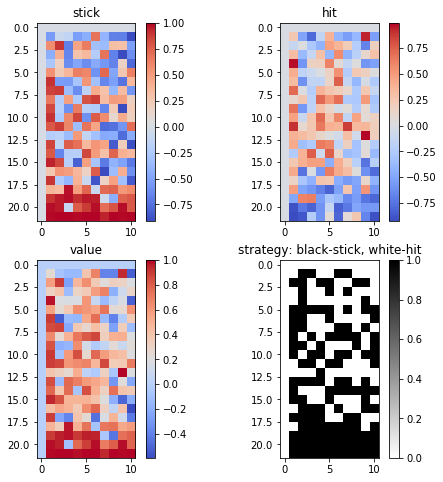

 80%|███████▉  | 79582/100000 [00:09<00:01, 11026.39it/s]

average rewards is -0.07845


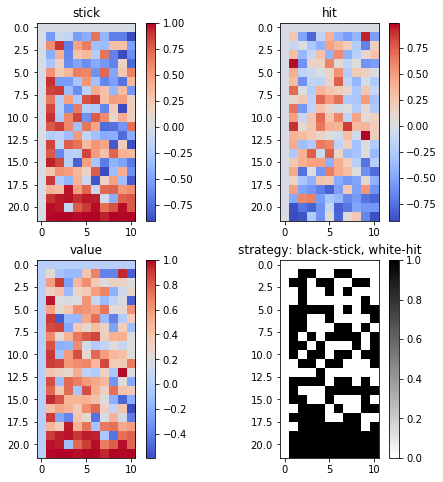

 99%|█████████▉| 99126/100000 [00:12<00:00, 10746.05it/s]

average rewards is -0.08435


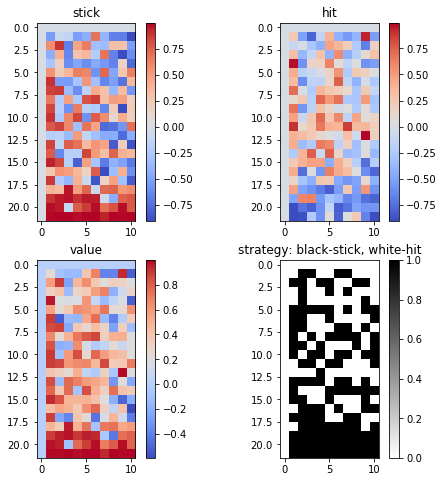

  1%|          | 1006/100000 [00:00<00:09, 10056.29it/s]

evaluate lambda 0.5


 19%|█▉        | 19403/100000 [00:01<00:07, 10653.99it/s]

average rewards is -0.0855


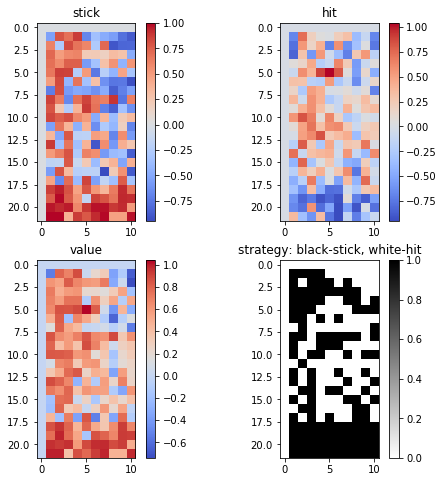

 39%|███▉      | 39083/100000 [00:04<00:05, 10967.62it/s]

average rewards is -0.05635


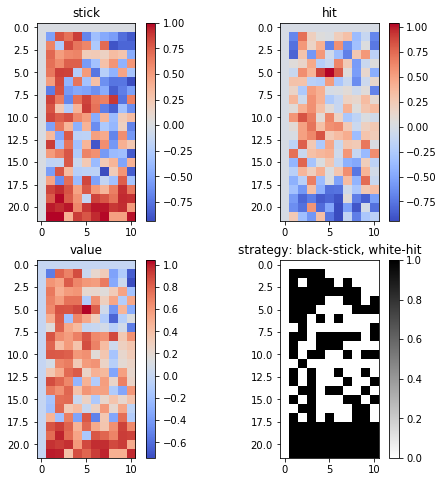

 59%|█████▉    | 59371/100000 [00:07<00:03, 11036.28it/s]

average rewards is -0.0523


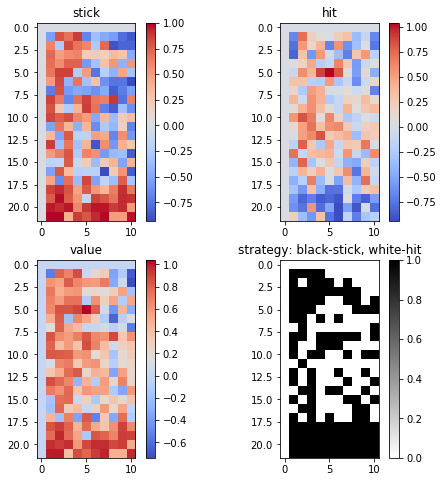

 79%|███████▉  | 79347/100000 [00:09<00:01, 11200.03it/s]

average rewards is -0.05895


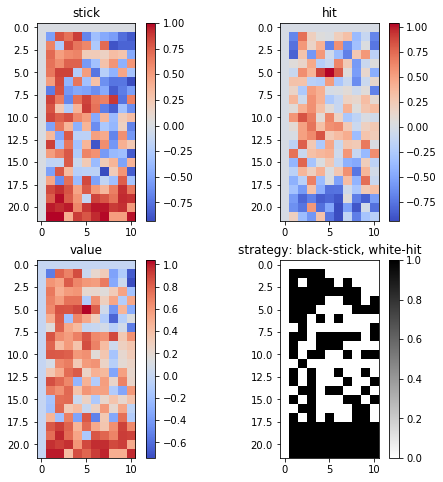

100%|█████████▉| 99597/100000 [00:12<00:00, 10756.06it/s]

average rewards is -0.05275


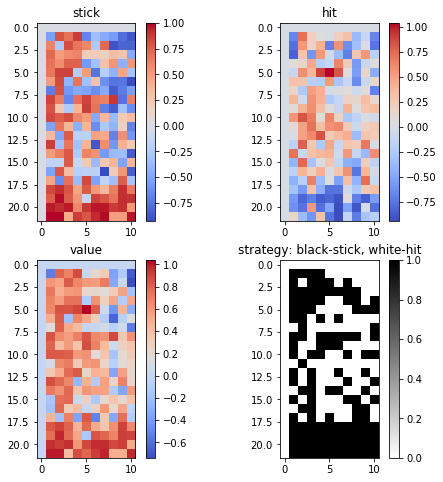

  1%|          | 988/100000 [00:00<00:10, 9877.73it/s]

evaluate lambda 0.6000000000000001


 19%|█▉        | 19494/100000 [00:01<00:07, 10583.16it/s]

average rewards is -0.09295


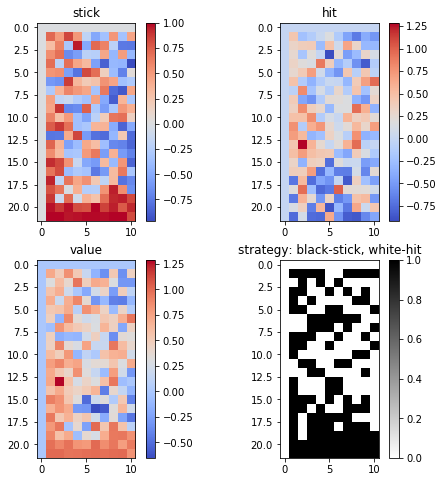

 39%|███▉      | 39289/100000 [00:04<00:06, 10036.03it/s]

average rewards is -0.08655


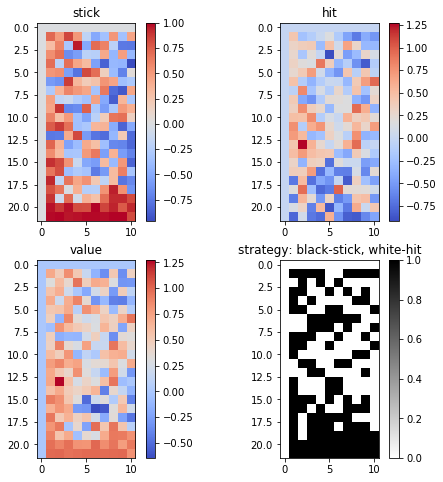

 59%|█████▉    | 59240/100000 [00:07<00:03, 10379.60it/s]

average rewards is -0.0739


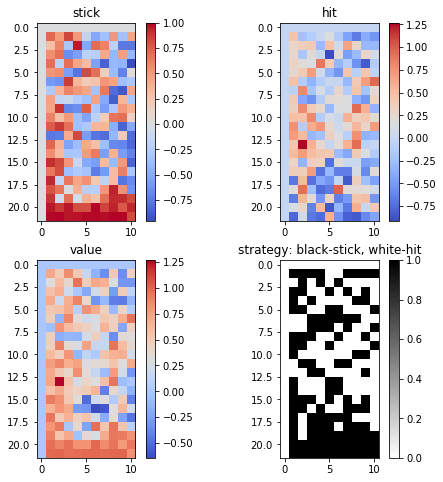

 79%|███████▉  | 79151/100000 [00:09<00:01, 10578.55it/s]

average rewards is -0.07505


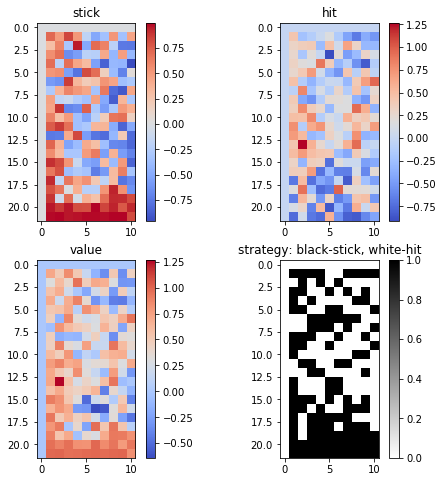

 99%|█████████▉| 99136/100000 [00:12<00:00, 10381.58it/s]

average rewards is -0.06575


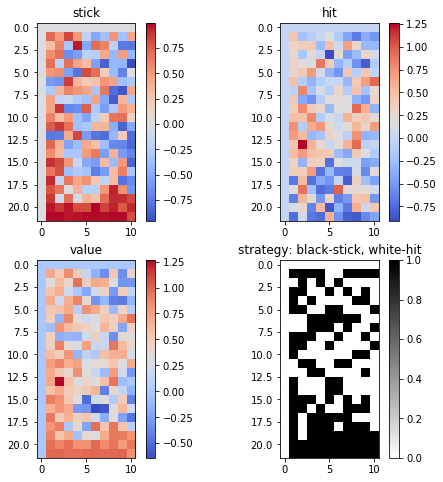

  1%|          | 1086/100000 [00:00<00:09, 10855.53it/s]

evaluate lambda 0.7000000000000001


 20%|█▉        | 19578/100000 [00:01<00:08, 10046.76it/s]

average rewards is -0.1156


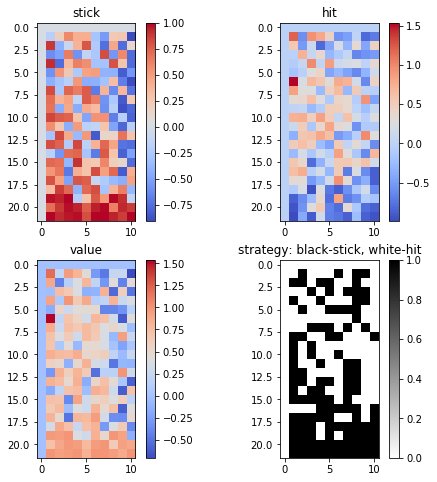

 39%|███▉      | 39115/100000 [00:04<00:06, 9994.95it/s] 

average rewards is -0.10155


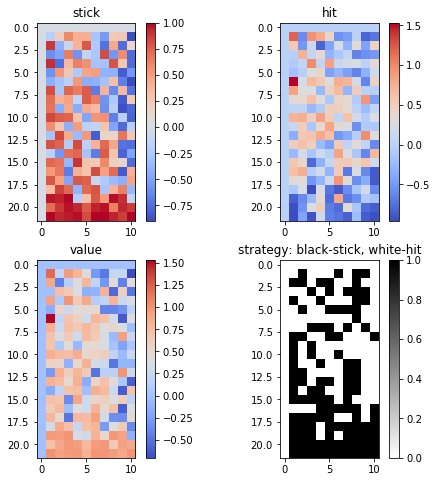

 60%|█████▉    | 59749/100000 [00:07<00:03, 10072.73it/s]

average rewards is -0.11045


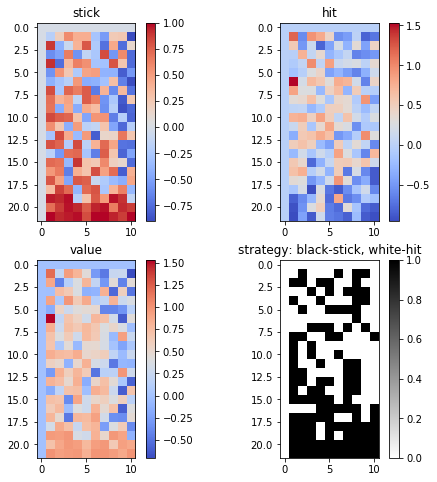

 79%|███████▉  | 79363/100000 [00:09<00:02, 9949.97it/s] 

average rewards is -0.1005


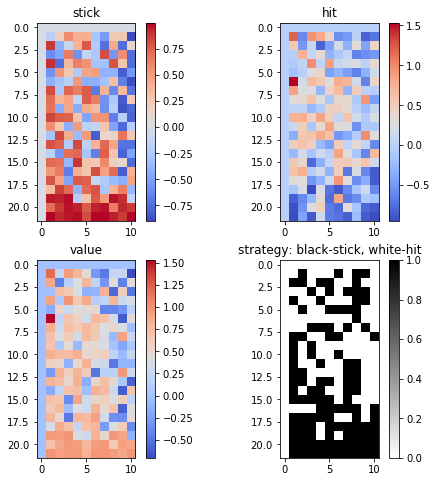

 99%|█████████▉| 99205/100000 [00:12<00:00, 9875.95it/s] 

average rewards is -0.09775


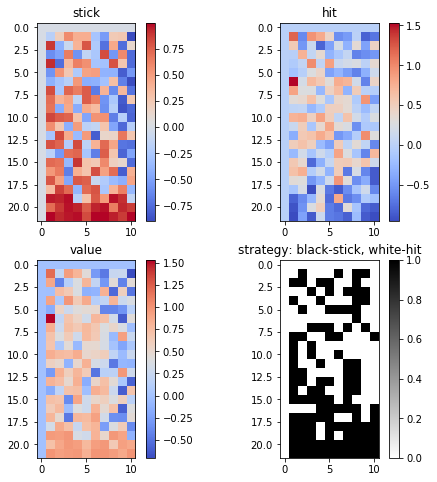

  1%|          | 614/100000 [00:00<00:16, 6137.52it/s]

evaluate lambda 0.8


 20%|█▉        | 19509/100000 [00:02<00:08, 10058.22it/s]

average rewards is -0.11545


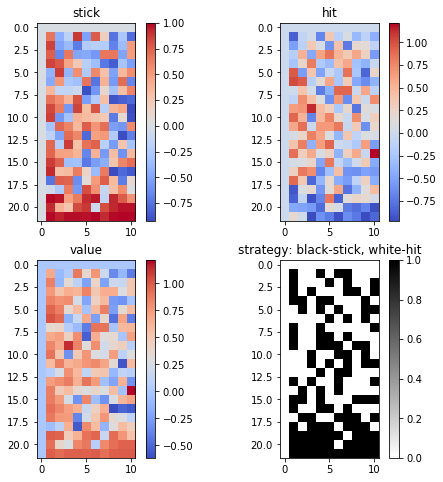

 39%|███▉      | 39013/100000 [00:04<00:06, 10161.11it/s]

average rewards is -0.1126


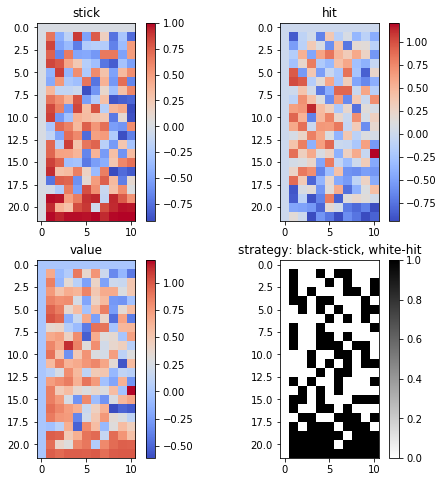

 59%|█████▉    | 59266/100000 [00:07<00:04, 9157.54it/s] 

average rewards is -0.11145


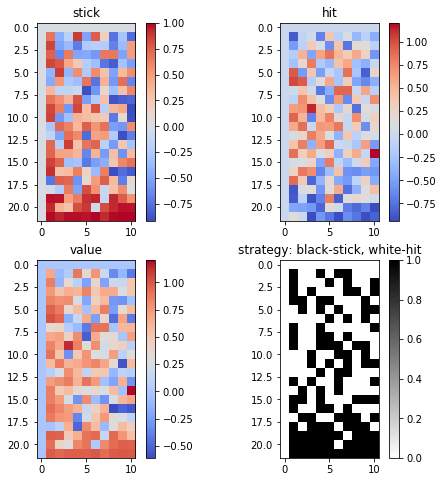

 79%|███████▉  | 79126/100000 [00:10<00:02, 8261.61it/s]

average rewards is -0.10555


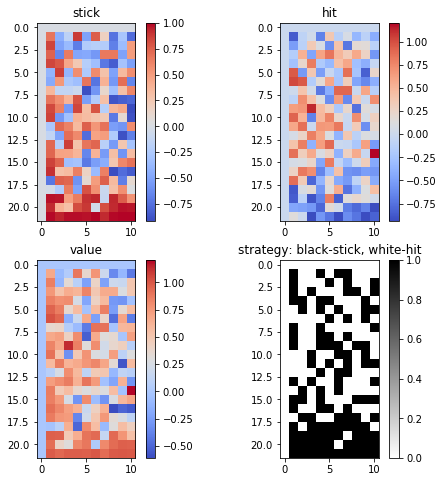

100%|█████████▉| 99532/100000 [00:13<00:00, 10406.48it/s]

average rewards is -0.11205


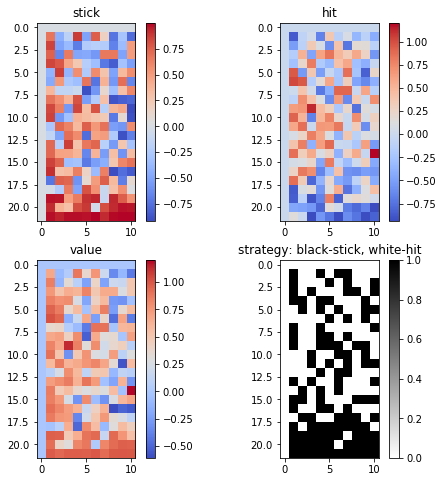

  1%|          | 1035/100000 [00:00<00:09, 10343.13it/s]

evaluate lambda 0.9


 19%|█▉        | 19420/100000 [00:01<00:07, 10809.26it/s]

average rewards is -0.0861


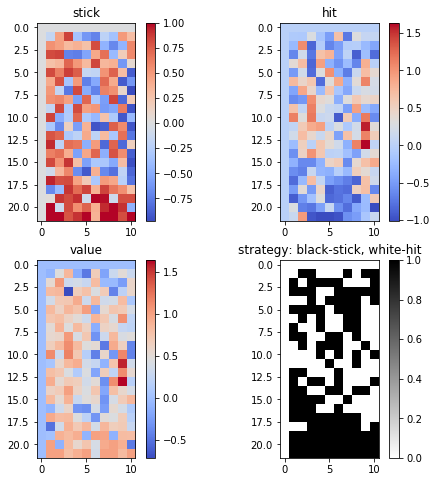

 39%|███▉      | 39172/100000 [00:04<00:06, 9861.81it/s] 

average rewards is -0.05275


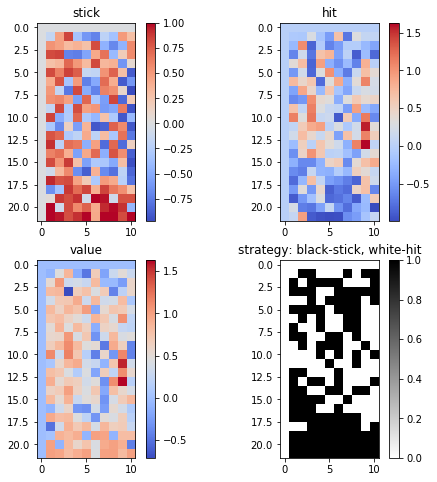

 60%|█████▉    | 59834/100000 [00:07<00:04, 10035.30it/s]

average rewards is -0.05255


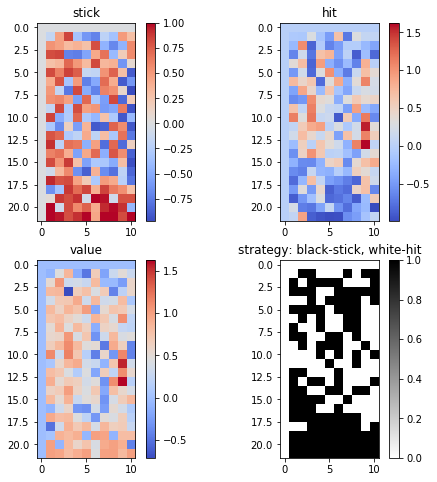

 79%|███████▉  | 79430/100000 [00:09<00:01, 10314.80it/s]

average rewards is -0.0398


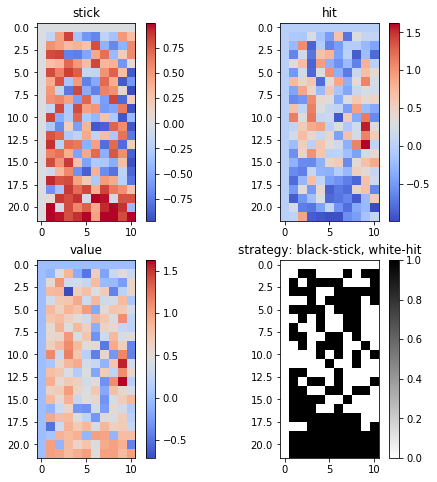

100%|█████████▉| 99978/100000 [00:12<00:00, 10564.90it/s]

average rewards is -0.05655


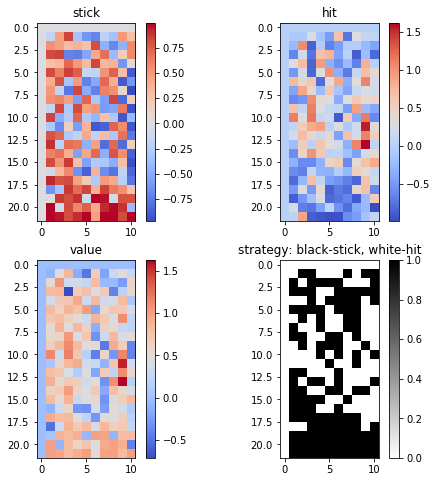

  1%|          | 877/100000 [00:00<00:11, 8768.06it/s]

evaluate lambda 1.0


 19%|█▉        | 19474/100000 [00:02<00:08, 8967.28it/s] 

average rewards is -0.1498


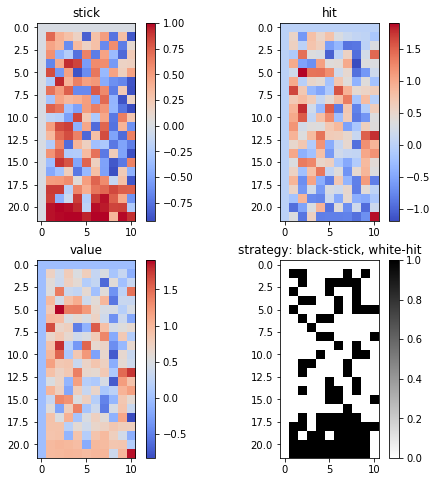

 39%|███▉      | 39130/100000 [00:04<00:06, 9447.42it/s]

average rewards is -0.1525


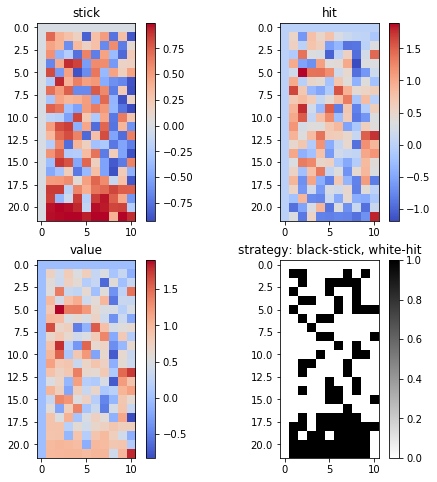

 59%|█████▉    | 59165/100000 [00:07<00:04, 9016.62it/s]

average rewards is -0.1539


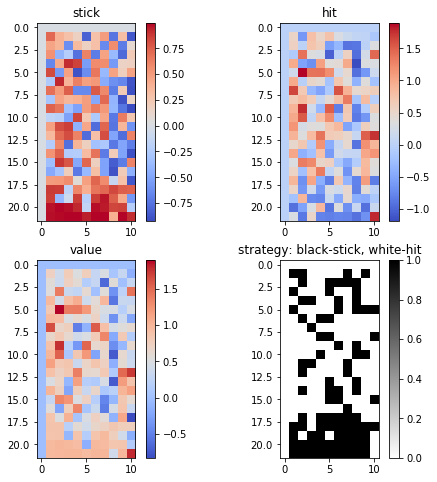

 80%|███████▉  | 79949/100000 [00:10<00:02, 8992.67it/s]

average rewards is -0.15885


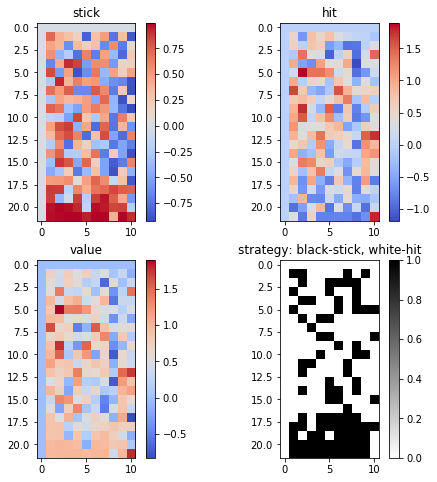

 99%|█████████▉| 99483/100000 [00:13<00:00, 9197.27it/s]

average rewards is -0.15875


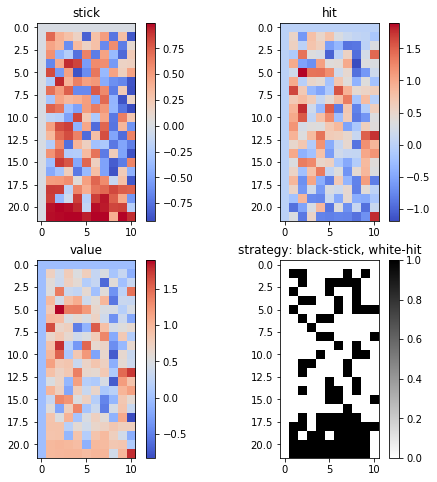

100%|██████████| 100000/100000 [00:14<00:00, 7016.70it/s]


In [22]:
mse_lambda = {}
for lambda_ in [x * 0.1 for x in range(11)]:
    print ('evaluate lambda {}'.format(lambda_))
    
    q_table = np.zeros((22,11,2)) #0 stick, 1 hit
    e_table = np.zeros((22,11,2))
    num_sa = np.zeros((22,11,2))
    num_s = np.zeros((22,11))

    n_0 = 100
    
    debug = False

    episode = 100000

    show_every = 20000
    cal_every = 1000
    mse = []

    rewards = np.zeros(show_every)

    params = {'lambda': lambda_}

    game = Easy21(debug=debug)

    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

        if e%show_every == show_every - 1:
            fig = plot_q(q_table)

        if e%cal_every == cal_every - 1:
            mse.append(mean_square_error())
            
    mse_lambda[lambda_] = mse

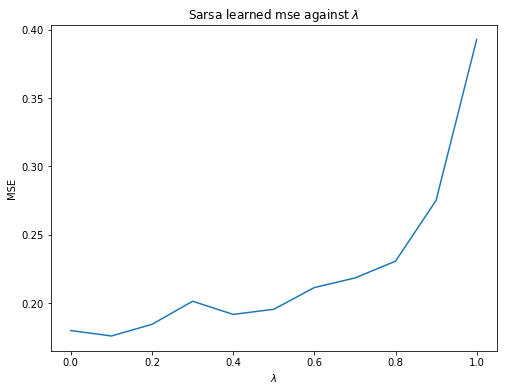

In [23]:
mse = []
for lambda_ in [x * 0.1 for x in range(11)]:
    mse.append(mse_lambda[lambda_][-1])
    
fig = plt.figure(figsize=(8,6))
plt.plot([x * 0.1 for x in range(11)], mse)
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Sarsa learned mse against $\lambda$')
plt.show()

In [24]:
fig.savefig('mse against lambda')

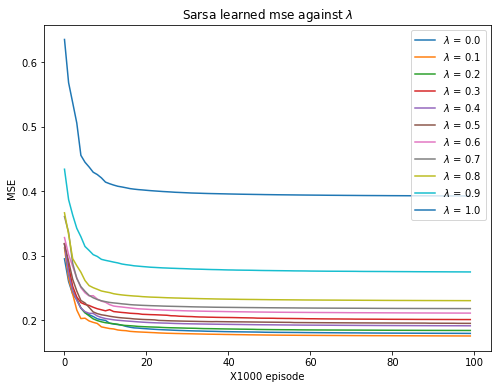

In [25]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
for lambda_ in [x * 0.1 for x in range(11)]:
    mse = mse_lambda[lambda_]
    ax.plot(range(len(mse)), mse, 
             label='$\lambda$ = {:1.1f}'.format(lambda_))
ax.legend(loc='upper right')
plt.xlabel('X1000 episode')
plt.ylabel('MSE')
plt.title('Sarsa learned mse against $\lambda$')
plt.show()

In [192]:
fig.savefig('sarsa learning curve against lambda')

# Linear function approximation and Sarsa($\lambda$)

The state-action is encoded using the representation

dealer(s) = {[1; 4]; [4; 7]; [7; 10]}  
player(s) = {[1; 6]; [4; 9]; [7; 12]; [10; 15]; [13; 18]; [16; 21]}  
a = {hit; stick}  
where  
• dealer(s) is the value of the dealer’s first card (1-10)  
• sum(s) is the sum of the player’s cards (1-21)  

In [33]:
def to_dealer_code(dealer, code_scheme={}):
    length = code_scheme.get('length', 3)
    start = code_scheme.get('start', 1)
    end = code_scheme.get('end', 4)
    interval = code_scheme.get('interval', 3)
    
    dealer_code = np.zeros(length)
    for i in range(length):
        if dealer >= start + i * interval and dealer <= end + i * interval:
            dealer_code[i] = 1
    return dealer_code

In [34]:
def to_player_code(player, code_scheme={}):
    length = code_scheme.get('length', 6)
    start = code_scheme.get('start', 1)
    end = code_scheme.get('end', 6)
    interval = code_scheme.get('interval', 3)
    
    player_code = np.zeros(length)
    for i in range(length):
        if player >= start + i * interval and player <= end + i * interval:
            player_code[i] = 1
    return player_code        

In [22]:
def encode_sa(state, action, code_scheme=None):
    player_state, dealer_state = state
    code = np.zeros((6,3,2))
    if code_scheme is not None:
        player_scheme = code_scheme['player']
        dealer_scheme = code_scheme['dealer']
        player_code_l = player_scheme['length']
        dealer_code_l = dealer_scheme['length']
        code = np.zeros((player_code_l,dealer_code_l,2))
    else:
        player_scheme = {}
        dealer_scheme = {}
    # here we represent stick with 0, hit with 1
    player_code = to_player_code(player_state, player_scheme)
    dealer_code = to_dealer_code(dealer_state, dealer_scheme)
    for p_code in player_code.nonzero():
        for d_code in dealer_code.nonzero():
            code[p_code,d_code,action] = 1
    return code.flatten()

In [51]:
def eval_value(state, code_scheme=None):
    code_stick = encode_sa(state, 0, code_scheme)
    code_hit = encode_sa(state, 1, code_scheme)
    value = cal_q(code_stick)
    if value < cal_q(code_hit):
        value = cal_q(code_hit)
    return value

In [24]:
def cal_q(code):
    return (code * w).sum()

In [25]:
def update_w(dw):
    global w
    w += dw

In [57]:
def eval_mse(code_scheme=code_scheme):
    q_table = np.zeros((22,11,2))
    for player in range(1,22):
        for dealer in range(1,11):
            for action in range(2):
                state = (player, dealer)
                q_table[player, dealer, action] = cal_q(encode_sa(state, action, 
                                                       code_scheme))
    return np.mean((q_table - gt_q_table) ** 2)

In [27]:
# q_table = np.zeros((22,11,2)) #0 stick, 1 hit
# no more q_table, change to weights
w = np.zeros(36)
# e_table also changes
e_table = np.zeros(36)
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))
learning_rate = 0.01

In [69]:
debug = False

episode = 10000

show_every = 2000

rewards = np.zeros(show_every)

params = {'lambda': 0.9}

game = Easy21(debug=debug)

import warnings

# stop on warning
with warnings.catch_warnings():
    warnings.simplefilter('error')
    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params, func_appro=True)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

 30%|██▉       | 2974/10000 [00:00<00:01, 5928.73it/s]

average rewards is -0.058


 52%|█████▏    | 5157/10000 [00:00<00:00, 5562.25it/s]

average rewards is -0.0315


 70%|██████▉   | 6993/10000 [00:01<00:00, 5924.44it/s]

average rewards is -0.022


 88%|████████▊ | 8766/10000 [00:01<00:00, 5842.92it/s]

average rewards is -0.0605


100%|██████████| 10000/10000 [00:01<00:00, 5665.00it/s]

average rewards is -0.0285


In [81]:
mse_lambda = {}
for lambda_ in [x * 0.1 for x in range(11)]:
    print ('evaluate lambda {}'.format(lambda_))
    
    w = np.zeros(36)
    e_table = np.zeros(36)
    
    num_sa = np.zeros((22,11,2))
    num_s = np.zeros((22,11))
    learning_rate = 0.01
    n_0 = 100
    
    debug = False

    episode = 100000

    show_every = 20000
    cal_every = 1000
    mse = []

    rewards = np.zeros(show_every)

    params = {'lambda': lambda_}

    game = Easy21(debug=debug)

    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params, func_appro=True)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

        if e%cal_every == cal_every - 1:
            mse.append(eval_mse())
            
    mse_lambda[lambda_] = mse

  0%|          | 316/100000 [00:00<00:31, 3146.86it/s]

evaluate lambda 0.0


 21%|██        | 21084/100000 [00:03<00:12, 6455.76it/s]

average rewards is -0.04


 41%|████      | 40765/100000 [00:06<00:09, 6579.28it/s]

average rewards is -0.0128


 61%|██████▏   | 61303/100000 [00:09<00:05, 6738.97it/s]

average rewards is 0.02445


 81%|████████  | 81088/100000 [00:13<00:03, 5823.33it/s]

average rewards is 0.0092


  1%|          | 537/100000 [00:00<00:18, 5365.91it/s]

average rewards is 0.01155
evaluate lambda 0.1


 21%|██        | 20960/100000 [00:03<00:13, 6024.23it/s]

average rewards is -0.03645


 41%|████      | 40846/100000 [00:07<00:10, 5741.23it/s]

average rewards is -0.01175


 61%|██████    | 61186/100000 [00:10<00:06, 6020.84it/s]

average rewards is 0.0007


 81%|████████  | 81192/100000 [00:13<00:03, 5952.08it/s]

average rewards is 0.02565


  1%|          | 584/100000 [00:00<00:17, 5839.09it/s]

average rewards is 0.0216
evaluate lambda 0.2


 21%|██        | 20985/100000 [00:03<00:12, 6152.33it/s]

average rewards is -0.0506


 41%|████      | 40528/100000 [00:07<00:13, 4345.47it/s]

average rewards is -0.01035


 61%|██████    | 60596/100000 [00:10<00:06, 5754.10it/s]

average rewards is 0.01085


 81%|████████  | 81079/100000 [00:13<00:03, 6152.39it/s]

average rewards is 0.02335


  1%|          | 545/100000 [00:00<00:18, 5447.64it/s]

average rewards is 0.02855
evaluate lambda 0.30000000000000004


 21%|██        | 20796/100000 [00:03<00:13, 5888.93it/s]

average rewards is -0.05325


 41%|████      | 40871/100000 [00:06<00:09, 6001.14it/s]

average rewards is 0.0048


 61%|██████    | 61175/100000 [00:10<00:06, 6374.38it/s]

average rewards is 0.0089


 81%|████████  | 80645/100000 [00:13<00:03, 6341.41it/s]

average rewards is 0.02215


  1%|          | 584/100000 [00:00<00:17, 5837.28it/s]

average rewards is 0.0366
evaluate lambda 0.4


 21%|██        | 20775/100000 [00:03<00:12, 6526.62it/s]

average rewards is -0.0344


 41%|████      | 41105/100000 [00:06<00:08, 6589.04it/s]

average rewards is -0.0161


 61%|██████    | 60844/100000 [00:09<00:06, 6315.91it/s]

average rewards is 0.0149


 81%|████████  | 80586/100000 [00:13<00:03, 5679.88it/s]

average rewards is 0.01005


  1%|          | 605/100000 [00:00<00:16, 6018.00it/s]

average rewards is 0.0079
evaluate lambda 0.5


 21%|██        | 21145/100000 [00:03<00:12, 6175.95it/s]

average rewards is -0.04295


 41%|████      | 40891/100000 [00:06<00:09, 6146.54it/s]

average rewards is -0.0112


 61%|██████    | 60987/100000 [00:10<00:06, 6426.95it/s]

average rewards is 0.01475


 81%|████████  | 81065/100000 [00:13<00:02, 6513.13it/s]

average rewards is 0.01875


  1%|          | 570/100000 [00:00<00:17, 5689.02it/s]

average rewards is 0.0147
evaluate lambda 0.6000000000000001


 21%|██        | 21222/100000 [00:03<00:13, 5887.09it/s]

average rewards is -0.04115


 41%|████      | 40957/100000 [00:06<00:09, 6394.47it/s]

average rewards is -0.00445


 61%|██████    | 61011/100000 [00:10<00:06, 6348.06it/s]

average rewards is 0.02595


 80%|████████  | 80489/100000 [00:13<00:03, 5391.92it/s]

average rewards is 0.01495


  1%|          | 586/100000 [00:00<00:16, 5859.08it/s]

average rewards is 0.0246
evaluate lambda 0.7000000000000001


 21%|██        | 20680/100000 [00:03<00:12, 6104.61it/s]

average rewards is -0.0361


 41%|████      | 40888/100000 [00:06<00:09, 6162.15it/s]

average rewards is -0.01225


 61%|██████    | 60662/100000 [00:09<00:05, 6591.35it/s]

average rewards is 0.02815


 81%|████████  | 81190/100000 [00:13<00:03, 6221.00it/s]

average rewards is 0.00715


  1%|          | 570/100000 [00:00<00:17, 5698.86it/s]

average rewards is 0.03045
evaluate lambda 0.8


 20%|██        | 20437/100000 [00:03<00:12, 6220.60it/s]

average rewards is -0.03095


 41%|████      | 40553/100000 [00:06<00:10, 5465.06it/s]

average rewards is 0.0037


 61%|██████    | 60691/100000 [00:09<00:06, 6131.33it/s]

average rewards is 0.01285


 81%|████████  | 80726/100000 [00:12<00:03, 5939.73it/s]

average rewards is 0.03285


  1%|          | 552/100000 [00:00<00:18, 5508.32it/s]

average rewards is 0.02295
evaluate lambda 0.9


 21%|██        | 21044/100000 [00:03<00:12, 6242.35it/s]

average rewards is -0.03435


 41%|████      | 40713/100000 [00:06<00:09, 6557.91it/s]

average rewards is 0.00895


 61%|██████    | 60913/100000 [00:09<00:05, 7268.93it/s]

average rewards is 0.021


 81%|████████  | 80943/100000 [00:12<00:02, 7186.89it/s]

average rewards is 0.01975


  1%|          | 614/100000 [00:00<00:16, 6115.35it/s]

average rewards is 0.01355
evaluate lambda 1.0


 21%|██        | 20744/100000 [00:03<00:12, 6586.30it/s]

average rewards is -0.03745


 41%|████▏     | 41395/100000 [00:06<00:08, 6851.32it/s]

average rewards is 0.0014


 61%|██████    | 61132/100000 [00:09<00:05, 6635.39it/s]

average rewards is 0.00895


 81%|████████  | 80536/100000 [00:12<00:02, 6606.20it/s]

average rewards is 0.00855


100%|██████████| 100000/100000 [00:15<00:00, 6592.38it/s]

average rewards is 0.02245


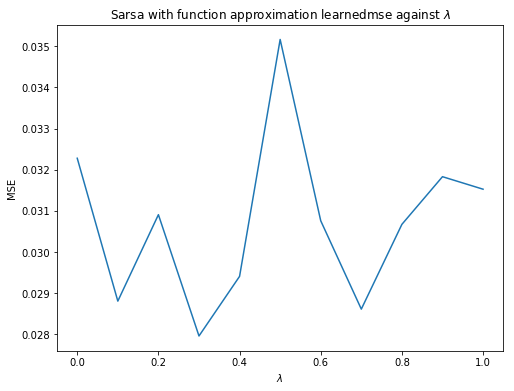

In [82]:
mse = []
for lambda_ in [x * 0.1 for x in range(11)]:
    mse.append(mse_lambda[lambda_][-1])
    
fig = plt.figure(figsize=(8,6))
plt.plot([x * 0.1 for x in range(11)], mse)
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Sarsa with function approximation learned' +
          'mse against $\lambda$')
plt.show()

In [83]:
fig.savefig('func appro mse against lambda')

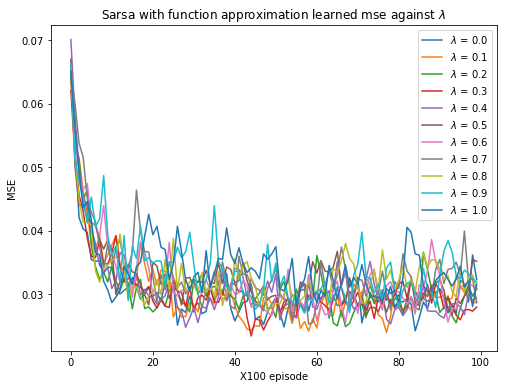

In [84]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
for lambda_ in [x * 0.1 for x in range(11)]:
    mse = mse_lambda[lambda_]
    ax.plot(range(len(mse)), mse, 
             label='$\lambda$ = {:1.1f}'.format(lambda_))
ax.legend(loc='upper right')
plt.xlabel('X100 episode')
plt.ylabel('MSE')
plt.title('Sarsa with function approximation ' + 
          'learned mse against $\lambda$')
plt.show()

In [85]:
fig.savefig('sarsa learning with function approximation ' +
            'curve against lambda')

## Alternative Coding Scheme

### Test

In [28]:
# q_table = np.zeros((22,11,2)) #0 stick, 1 hit
# no more q_table, change to weights
w = np.zeros(36)
# e_table also changes
e_table = np.zeros(36)
num_sa = np.zeros((22,11,2))
num_s = np.zeros((22,11))
learning_rate = 0.01

In [52]:
debug = False

episode = 10

show_every = 2000

rewards = np.zeros(show_every)

params = {'lambda': 0.9}
player_scheme = {'length': 7, 'start':1 ,'end':3 ,'interval': 3}
dealer_scheme = {'length': 4, 'start':0 ,'end':2,'interval': 3}
code_scheme = {'player': player_scheme, 'dealer': dealer_scheme}

e_table = np.zeros(56)
w = np.zeros(56)

game = Easy21(debug=debug)

import warnings

# stop on warning
with warnings.catch_warnings():
    warnings.simplefilter('error')
    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params, func_appro=True, 
                               code_scheme=code_scheme)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

100%|██████████| 10/10 [00:00<00:00, 2255.73it/s]


In [58]:
mse_lambda = {}
for lambda_ in [x * 0.1 for x in range(11)]:
    print ('evaluate lambda {}'.format(lambda_))

    player_scheme = {'length': 7, 'start':1 ,'end':3 ,'interval': 3}
    dealer_scheme = {'length': 4, 'start':0 ,'end':2,'interval': 3}
    code_scheme = {'player': player_scheme, 'dealer': dealer_scheme}

    e_table = np.zeros(56)
    w = np.zeros(56)

    
    num_sa = np.zeros((22,11,2))
    num_s = np.zeros((22,11))
    learning_rate = 0.01
    n_0 = 100
    
    debug = False

    episode = 100000

    show_every = 20000
    cal_every = 1000
    mse = []

    rewards = np.zeros(show_every)

    params = {'lambda': lambda_}

    game = Easy21(debug=debug)

    for e in tqdm(range(episode)):
        reward = play_and_learn(game, 'sarsa', params, func_appro=True, 
                               code_scheme=code_scheme)
        rewards[e%show_every] = reward
        if e%show_every == show_every - 1:
            print ('average rewards is {}'.format(np.mean(rewards)))
            rewards = np.zeros(show_every)

        if e%cal_every == cal_every - 1:
            mse.append(eval_mse(code_scheme=code_scheme))
            
    mse_lambda[lambda_] = mse

  0%|          | 438/100000 [00:00<00:22, 4379.76it/s]

evaluate lambda 0.0


 21%|██        | 21073/100000 [00:03<00:12, 6336.04it/s]

average rewards is -0.02825


 41%|████      | 40617/100000 [00:07<00:09, 6014.84it/s]

average rewards is -0.0023


 61%|██████    | 60823/100000 [00:10<00:06, 5942.59it/s]

average rewards is 0.0075


 81%|████████  | 81000/100000 [00:13<00:03, 5739.25it/s]

average rewards is 0.01125


  1%|          | 510/100000 [00:00<00:19, 5097.87it/s]

average rewards is 0.0339
evaluate lambda 0.1


 21%|██        | 21054/100000 [00:03<00:12, 6454.97it/s]

average rewards is -0.0278


 41%|████      | 40980/100000 [00:06<00:09, 6092.04it/s]

average rewards is -0.0041


 61%|██████    | 61072/100000 [00:10<00:06, 5638.64it/s]

average rewards is 0.01855


 81%|████████  | 80842/100000 [00:13<00:03, 6091.95it/s]

average rewards is 0.00895


  1%|          | 540/100000 [00:00<00:18, 5385.01it/s]

average rewards is 0.0361
evaluate lambda 0.2


 21%|██        | 20787/100000 [00:03<00:13, 5954.78it/s]

average rewards is -0.0416


 41%|████      | 40922/100000 [00:06<00:09, 6173.58it/s]

average rewards is -0.004


 61%|██████    | 60590/100000 [00:10<00:06, 5791.89it/s]

average rewards is 0.03025


 81%|████████  | 80759/100000 [00:13<00:03, 5767.52it/s]

average rewards is 0.00665


  0%|          | 497/100000 [00:00<00:20, 4967.03it/s]

average rewards is 0.03575
evaluate lambda 0.30000000000000004


 21%|██        | 20843/100000 [00:03<00:12, 6195.27it/s]

average rewards is -0.03195


 41%|████      | 40862/100000 [00:06<00:09, 5987.59it/s]

average rewards is 0.01905


 61%|██████    | 61200/100000 [00:10<00:06, 5965.53it/s]

average rewards is -0.01135


 81%|████████  | 80997/100000 [00:13<00:02, 6382.67it/s]

average rewards is 0.0228


  1%|          | 556/100000 [00:00<00:17, 5555.44it/s]

average rewards is 0.02115
evaluate lambda 0.4


 21%|██        | 21001/100000 [00:03<00:13, 5765.21it/s]

average rewards is -0.03045


 41%|████      | 41142/100000 [00:06<00:09, 5986.94it/s]

average rewards is -0.0003


 61%|██████    | 60904/100000 [00:10<00:06, 5766.11it/s]

average rewards is 0.01235


 81%|████████  | 80667/100000 [00:13<00:03, 6397.77it/s]

average rewards is 0.02


  1%|          | 581/100000 [00:00<00:17, 5797.00it/s]

average rewards is 0.02415
evaluate lambda 0.5


 21%|██        | 21000/100000 [00:03<00:11, 6721.29it/s]

average rewards is -0.0202


 41%|████      | 41056/100000 [00:06<00:09, 6045.79it/s]

average rewards is -0.0054


 61%|██████    | 61041/100000 [00:09<00:06, 6300.52it/s]

average rewards is 0.01525


 81%|████████  | 80569/100000 [00:13<00:03, 5856.93it/s]

average rewards is 0.0167


  1%|          | 525/100000 [00:00<00:18, 5245.60it/s]

average rewards is 0.02245
evaluate lambda 0.6000000000000001


 21%|██▏       | 21283/100000 [00:03<00:11, 6627.32it/s]

average rewards is -0.02755


 41%|████      | 40935/100000 [00:06<00:09, 6372.16it/s]

average rewards is 0.00995


 61%|██████    | 60925/100000 [00:09<00:06, 5876.01it/s]

average rewards is 0.02355


 81%|████████  | 80737/100000 [00:13<00:03, 5982.17it/s]

average rewards is 0.0135


  1%|          | 560/100000 [00:00<00:17, 5595.47it/s]

average rewards is 0.02365
evaluate lambda 0.7000000000000001


 21%|██        | 20870/100000 [00:03<00:12, 6349.42it/s]

average rewards is -0.03515


 41%|████▏     | 41385/100000 [00:06<00:08, 6994.16it/s]

average rewards is 0.03


 61%|██████    | 61041/100000 [00:09<00:06, 6138.00it/s]

average rewards is 0.0189


 81%|████████  | 81000/100000 [00:12<00:03, 6070.54it/s]

average rewards is 0.0217


  1%|          | 580/100000 [00:00<00:17, 5794.78it/s]

average rewards is 0.0265
evaluate lambda 0.8


 21%|██        | 21000/100000 [00:03<00:12, 6301.58it/s]

average rewards is -0.01925


 41%|████      | 41126/100000 [00:06<00:09, 5949.65it/s]

average rewards is -0.00365


 61%|██████    | 60882/100000 [00:09<00:06, 6456.33it/s]

average rewards is 0.0166


 81%|████████  | 81232/100000 [00:12<00:02, 6608.17it/s]

average rewards is 0.0248


  1%|          | 571/100000 [00:00<00:17, 5707.62it/s]

average rewards is 0.0233
evaluate lambda 0.9


 21%|██        | 20810/100000 [00:03<00:11, 6634.64it/s]

average rewards is -0.034


 41%|████      | 40946/100000 [00:06<00:08, 6958.65it/s]

average rewards is 0.00165


 61%|██████    | 61027/100000 [00:09<00:06, 6295.10it/s]

average rewards is 0.0059


 81%|████████  | 80934/100000 [00:12<00:02, 6988.45it/s]

average rewards is 0.0442


  1%|          | 531/100000 [00:00<00:18, 5300.01it/s]

average rewards is 0.0351
evaluate lambda 1.0


 21%|██        | 20787/100000 [00:03<00:12, 6449.07it/s]

average rewards is -0.02395


 41%|████      | 40912/100000 [00:06<00:08, 6705.47it/s]

average rewards is 0.0106


 61%|██████    | 60921/100000 [00:09<00:06, 6286.34it/s]

average rewards is 0.0186


 81%|████████▏ | 81326/100000 [00:12<00:02, 6870.84it/s]

average rewards is 0.0291


100%|██████████| 100000/100000 [00:15<00:00, 6391.20it/s]

average rewards is 0.04295


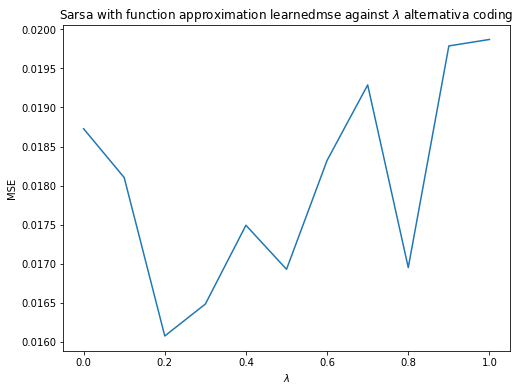

In [60]:
mse = []
for lambda_ in [x * 0.1 for x in range(11)]:
    mse.append(mse_lambda[lambda_][-1])
    
fig = plt.figure(figsize=(8,6))
plt.plot([x * 0.1 for x in range(11)], mse)
plt.xlabel('$\lambda$')
plt.ylabel('MSE')
plt.title('Sarsa with function approximation learned' +
          'mse against $\lambda$ alternativa coding')
plt.show()

In [61]:
fig.savefig('func appro mse against lambda alternative coding')

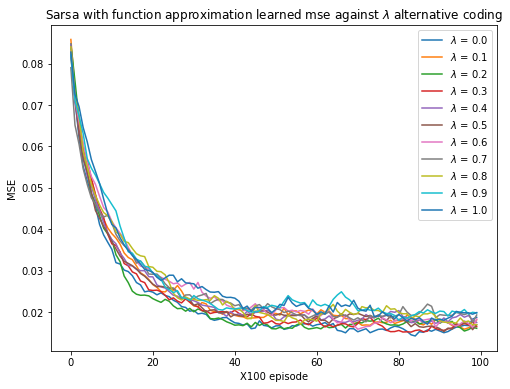

In [62]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
for lambda_ in [x * 0.1 for x in range(11)]:
    mse = mse_lambda[lambda_]
    ax.plot(range(len(mse)), mse, 
             label='$\lambda$ = {:1.1f}'.format(lambda_))
ax.legend(loc='upper right')
plt.xlabel('X100 episode')
plt.ylabel('MSE')
plt.title('Sarsa with function approximation ' + 
          'learned mse against $\lambda$ alternative coding')
plt.show()

In [63]:
fig.savefig('sarsa learning with function approximation ' +
            'curve against lambda alternative coding')